In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split

import xgboost as xgb
from sklearn.svm import SVC, SVR

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, precision_recall_curve,balanced_accuracy_score,make_scorer,f1_score,classification_report

# Czy leci z nami pilot?

The NTSB aviation accident database contains information from 1962 and later about civil aviation accidents and selected incidents within the United States, its territories and possessions, and in international waters.

In [2]:
df = pd.read_csv("AviationData.csv", usecols = ['Event.Id','Investigation.Type','Event.Date', 'Location','Aircraft.damage','Make','Model','Engine.Type','Number.of.Engines','Purpose.of.flight','Weather.Condition','Broad.phase.of.flight','Injury.Severity','Total.Fatal.Injuries'], parse_dates = ['Event.Date'], encoding = "ISO-8859-1")

C:\Users\sebas\AppData\Local\Temp\ipykernel_24612\713402779.py:1: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("AviationData.csv", usecols = ['Event.Id','Investigation.Type','Event.Date', 'Location','Aircraft.damage','Make','Model','Engine.Type','Number.of.Engines','Purpose.of.flight','Weather.Condition','Broad.phase.of.flight','Injury.Severity','Total.Fatal.Injuries'], parse_dates = ['Event.Date'], encoding = "ISO-8859-1")


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Event.Id               88889 non-null  object        
 1   Investigation.Type     88889 non-null  object        
 2   Event.Date             88889 non-null  datetime64[ns]
 3   Location               88837 non-null  object        
 4   Injury.Severity        87889 non-null  object        
 5   Aircraft.damage        85695 non-null  object        
 6   Make                   88826 non-null  object        
 7   Model                  88797 non-null  object        
 8   Number.of.Engines      82805 non-null  float64       
 9   Engine.Type            81812 non-null  object        
 10  Purpose.of.flight      82697 non-null  object        
 11  Total.Fatal.Injuries   77488 non-null  float64       
 12  Weather.Condition      84397 non-null  object        
 13  B

In [4]:
df.describe()

,Number.of.Engines,Total.Fatal.Injuries
count,82805.000000,77488.000000
mean,1.146585,0.647855
std,0.446510,5.485960
min,0.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,0.000000
max,8.000000,349.000000


### Czyszczenie danych przed analizą

In [5]:
# z kolumny 'Event.Date' wyciągamy do osobnych kolumn rok, miesiąc i dzień
df['Year'] = df['Event.Date'].dt.year
df['Month'] = df['Event.Date'].dt.month_name()
df['Day'] = df['Event.Date'].dt.day_name()

# z kolumny 'Location' wyciągamy do osbnych kolumn miasto i stan
df['City'] = df['Location'].str.split(',').str[0]
df['State'] = df['Location'].str.split(',').str[1]

# 'Unk' i 'UNK' zamieniamy na jedną wartość 'Unknown'
df['Weather.Condition'].replace(to_replace = ['Unk', 'UNK'], value = 'Unknown', inplace = True)

# wartości np. Fatal(1), Fatal(123) zamieniamy na jedną wartość 'Fatal'
df['Injury.Severity'] = df['Injury.Severity'].str.replace('Fatal.*', 'Fatal')

# puste wartości uzupełniamy najczęściej występującymi wartościami w danej kolumnie
df['Purpose.of.flight'] = df['Purpose.of.flight'].fillna(df['Purpose.of.flight'].mode()[0])
df['Weather.Condition'] = df['Weather.Condition'].fillna(df['Weather.Condition'].mode()[0])
df['Engine.Type'] = df['Engine.Type'].fillna(df['Engine.Type'].mode()[0])
df['Model'] = df['Model'].fillna(df['Model'].mode()[0])

# w kolumnie number.of.Engines średnia oraz mediana jest podabna, wiec uzupełniamy puste wartosci medianą
df['Number.of.Engines'].fillna(df['Number.of.Engines'].median(), inplace=True);

C:\Users\sebas\AppData\Local\Temp\ipykernel_24612\198806295.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Injury.Severity'] = df['Injury.Severity'].str.replace('Fatal.*', 'Fatal')


In [6]:
df = df.dropna()

In [7]:
df.groupby('Broad.phase.of.flight')['Total.Fatal.Injuries'].agg(['count', 'min', 'max', 'mean', 'sum'])

,count,min,max,mean,sum
Broad.phase.of.flight,,,,,
Approach,5415,0.0,228.0,0.705263,3819.0
Climb,1649,0.0,230.0,1.056398,1742.0
Cruise,8391,0.0,111.0,0.721249,6052.0
Descent,1454,0.0,82.0,0.621733,904.0
Go-around,1116,0.0,37.0,0.524194,585.0
Landing,11614,0.0,34.0,0.042793,497.0
Maneuvering,7104,0.0,68.0,0.741132,5265.0
Other,96,0.0,11.0,0.875000,84.0
Standing,553,0.0,34.0,0.195298,108.0


## Analiza

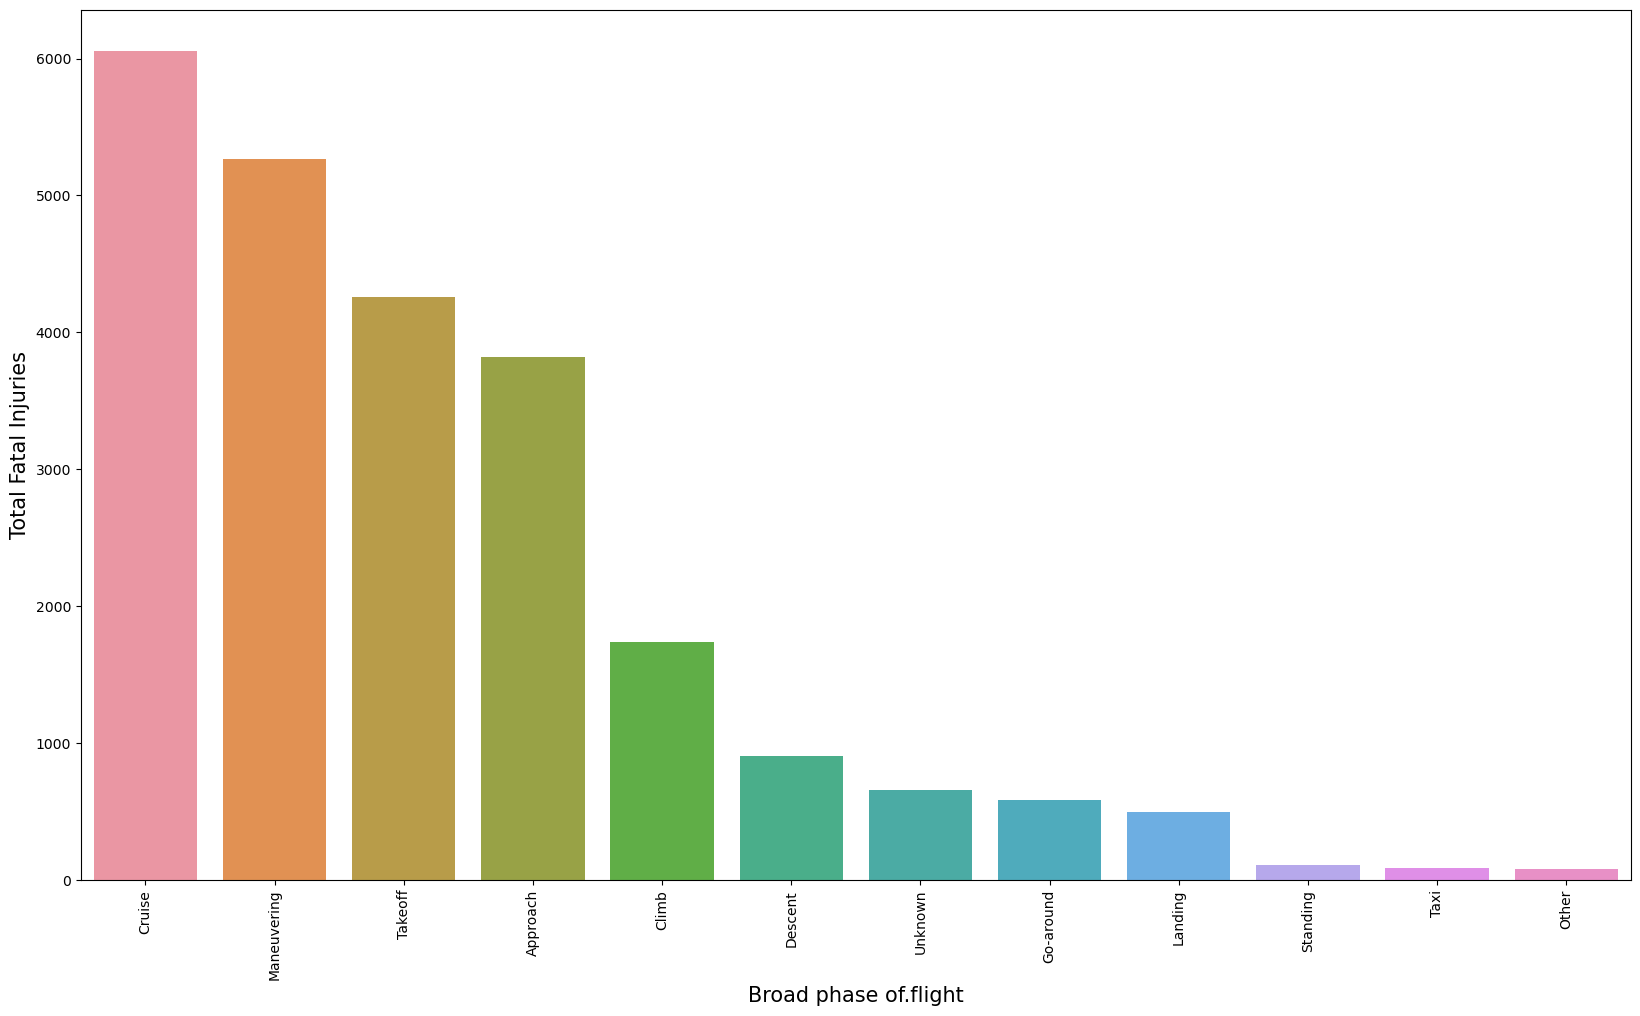

In [8]:
phase_flight_grouped= df.groupby("Broad.phase.of.flight").sum('Total.Fatal.Injuries').reset_index().sort_values(by='Total.Fatal.Injuries',ascending=False)

plt.figure(figsize=(20,11.3))
sns.barplot(data = phase_flight_grouped, x = phase_flight_grouped['Broad.phase.of.flight'],y= phase_flight_grouped['Total.Fatal.Injuries'], estimator = sum)
plt.xticks(rotation=90)
plt.xlabel("Broad phase of.flight", size=15)
plt.ylabel("Total Fatal Injuries", size=15)
plt.show()

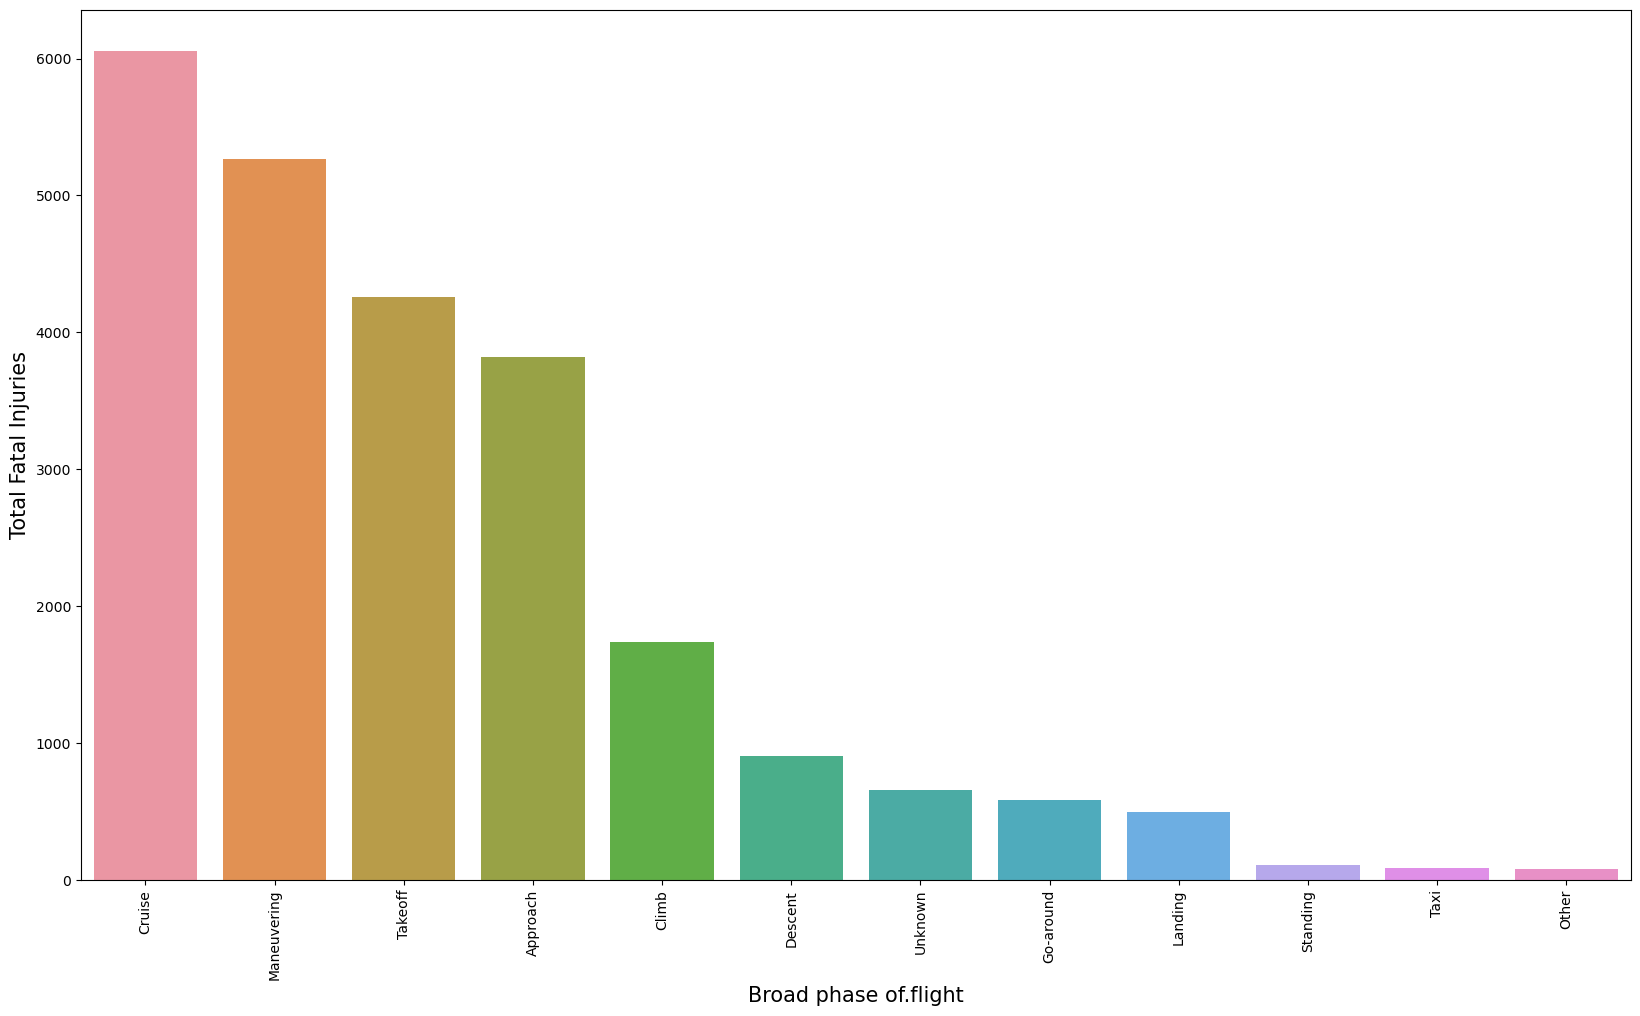

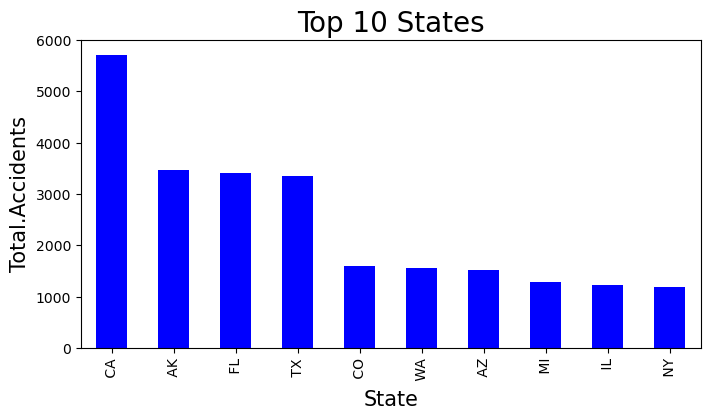

In [9]:
plt.figure(figsize=(8,4))
df['State'].str.upper().value_counts().sort_values(ascending=False)[:10].plot(kind='bar', color='Blue')
plt.xticks(rotation=90)
plt.xlabel("State", size=15)
plt.ylabel("Total.Accidents", size=15)
plt.title("Top 10 States", size=20)
plt.show()

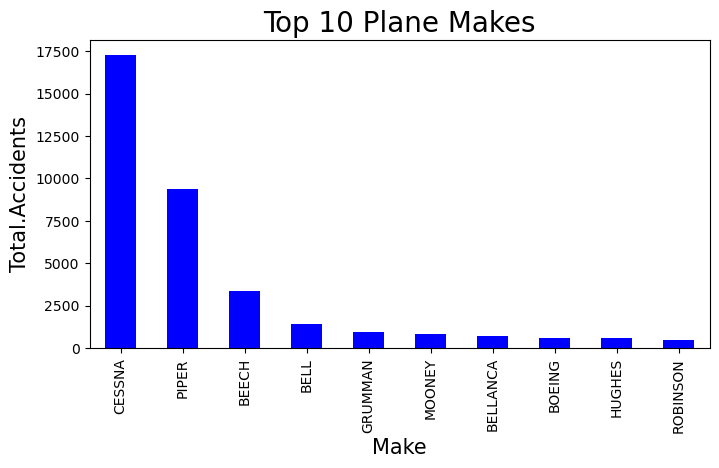

In [10]:
plt.figure(figsize=(8,4))
df['Make'].str.upper().value_counts().sort_values(ascending=False)[:10].plot(kind='bar', color='Blue')
plt.xticks(rotation=90)
plt.xlabel("Make", size=15)
plt.ylabel("Total.Accidents", size=15)
plt.title("Top 10 Plane Makes", size=20)
plt.show()

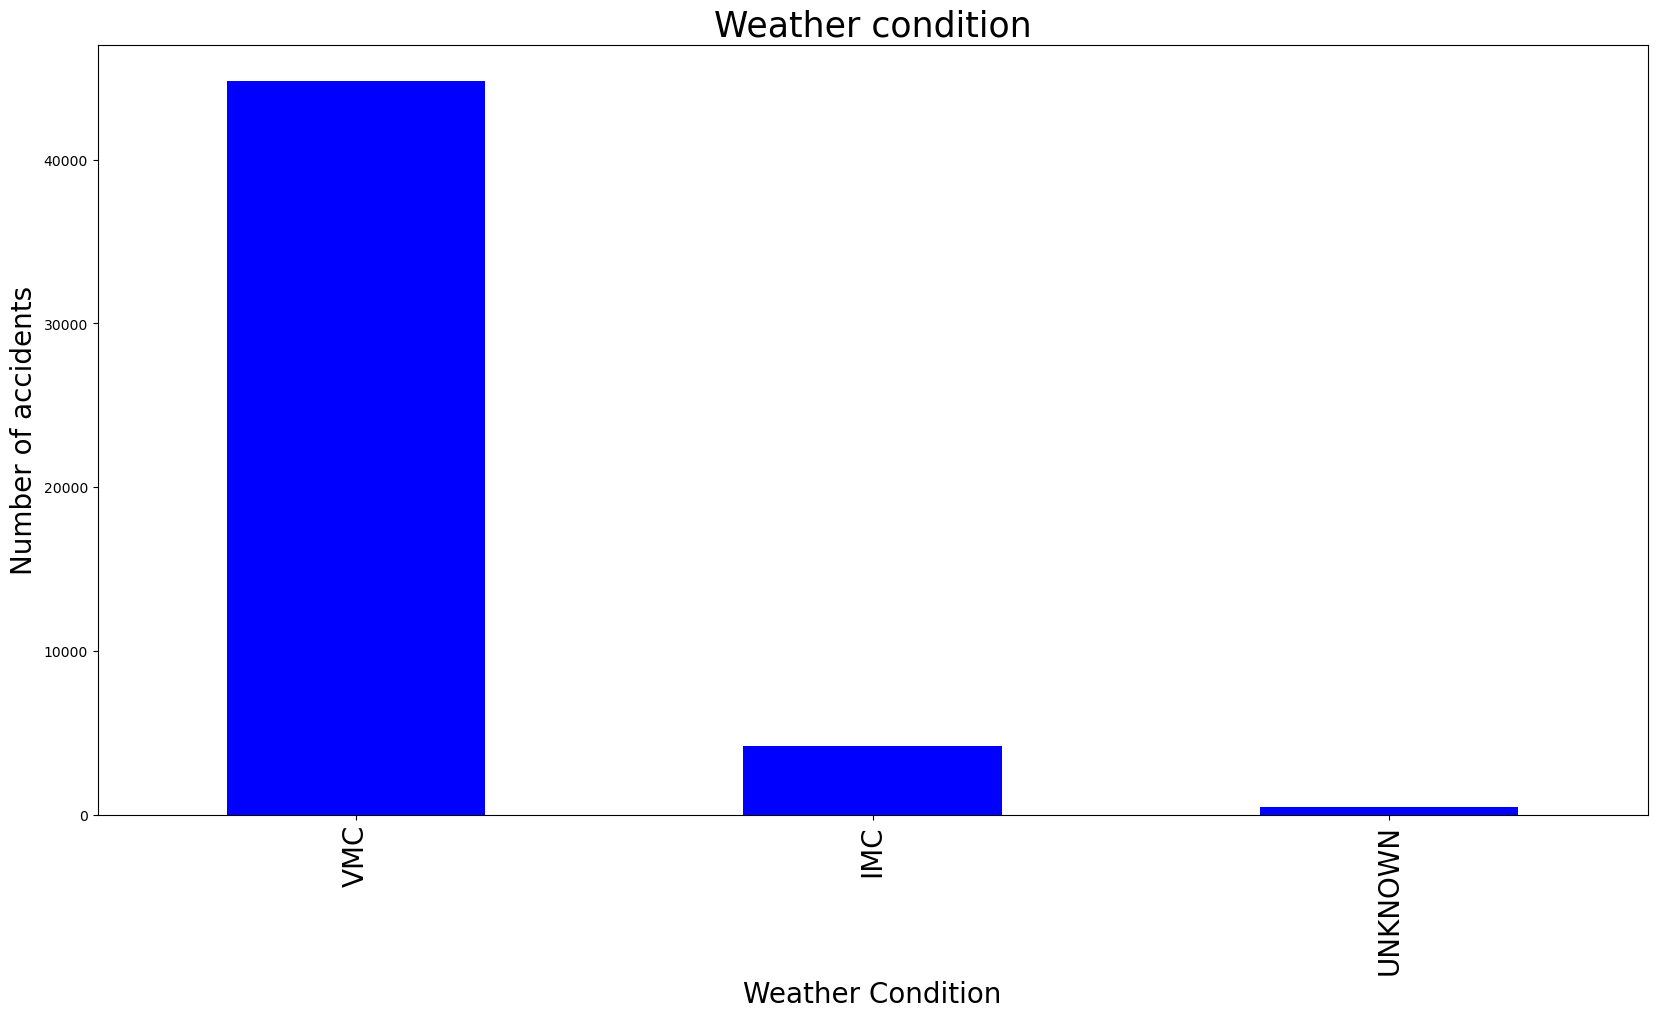

In [11]:
plt.figure(figsize=(20,10))
df['Weather.Condition'].str.upper().value_counts().sort_values(ascending=False)[:10].plot(kind='bar', color='Blue')
plt.xlabel("Weather Condition", size=20)
plt.ylabel("Number of accidents", size=20)
plt.title("Weather condition", size=25)
plt.xticks(size=20)
plt.show()

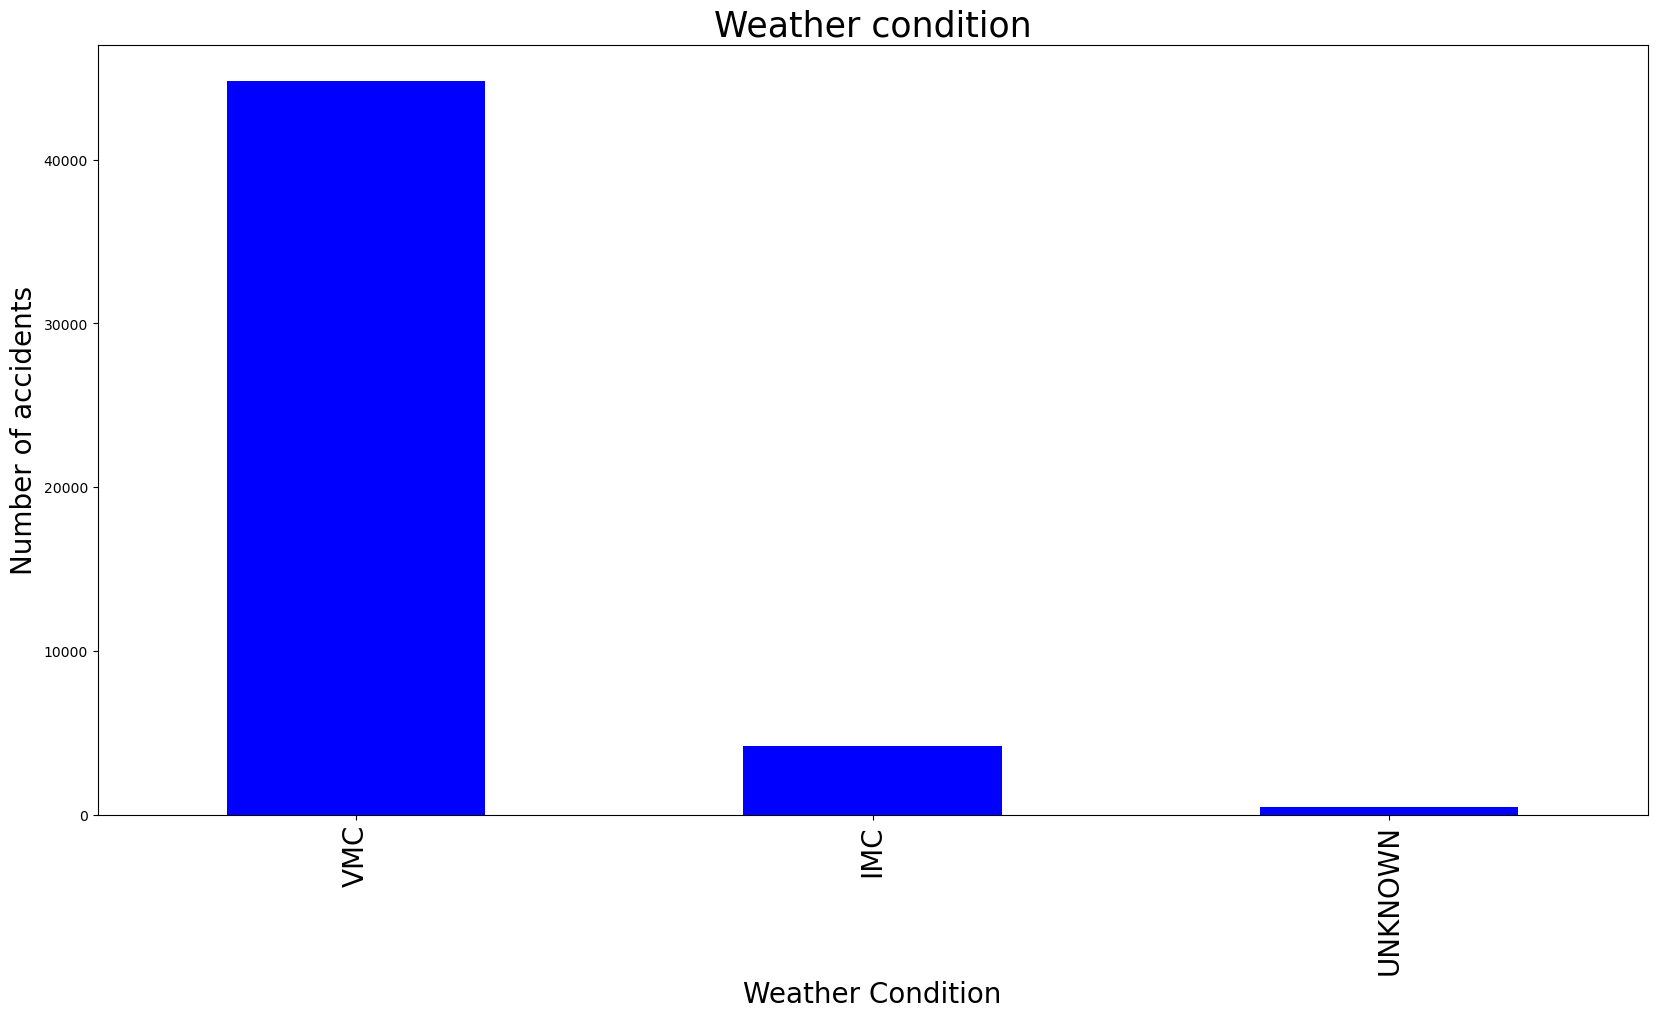

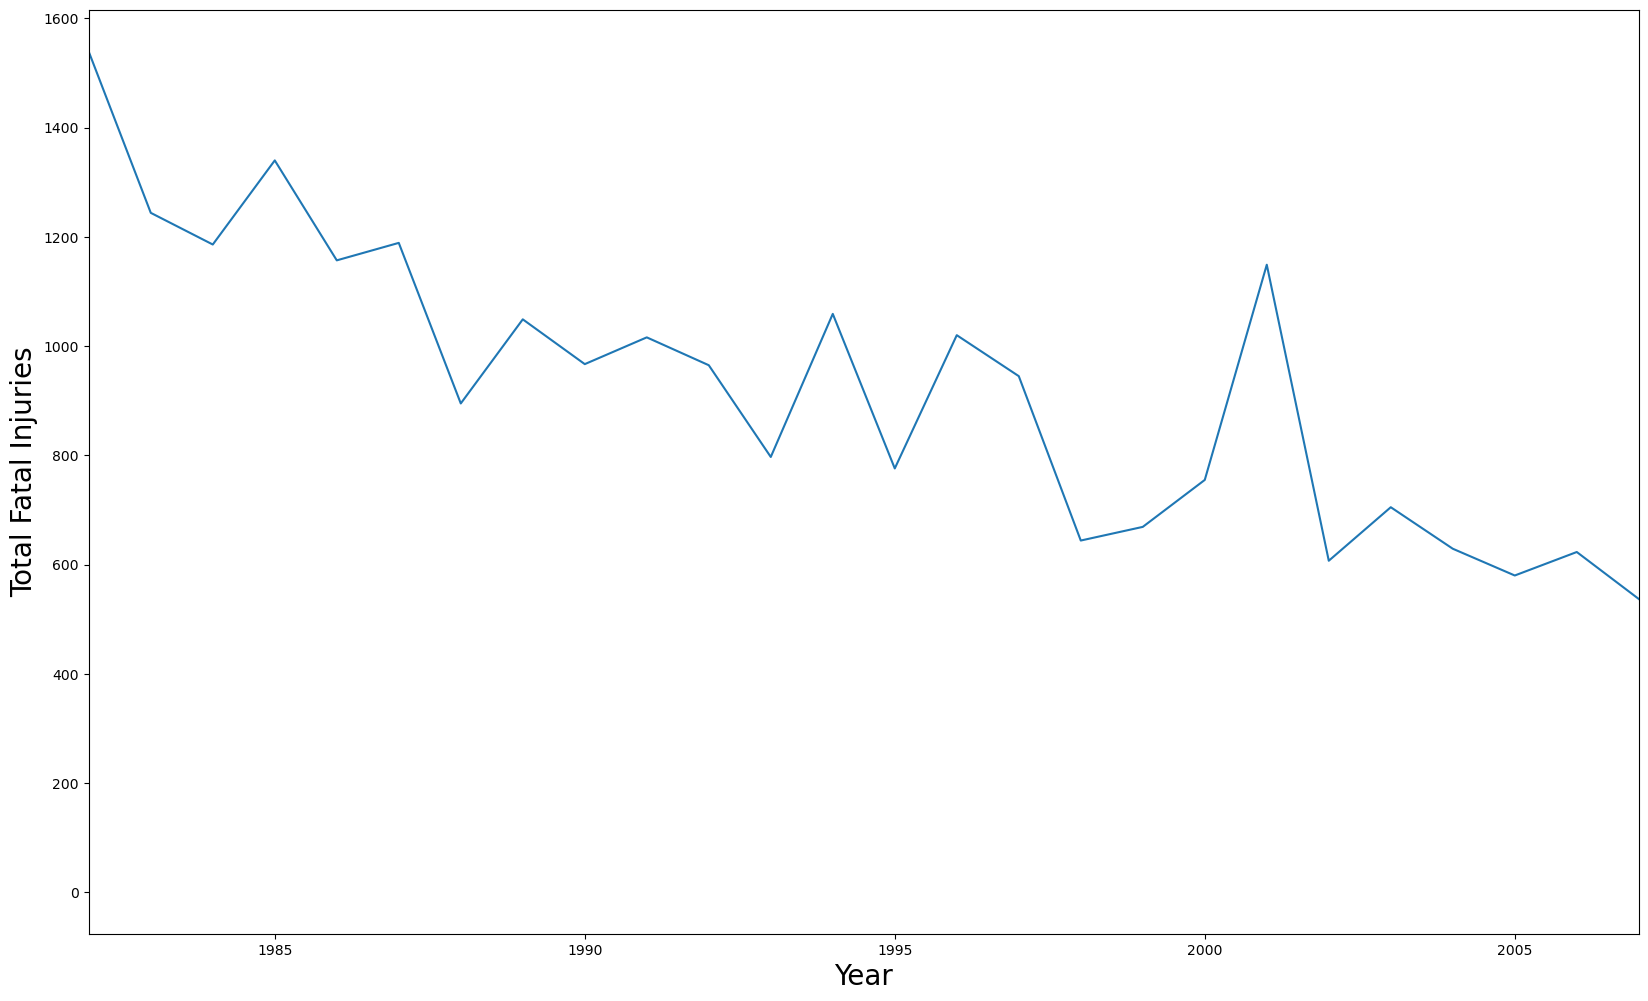

In [12]:
plt.figure(figsize = (20,12))
ax = sns.lineplot(data = df, x = df['Year'], y= df['Total.Fatal.Injuries'],estimator=sum,ci=None)
plt.ylabel('Total Fatal Injuries', size=20)
plt.xlabel('Year', size=20)
plt.xticks(size=10)
plt.yticks(size=10)
ax.set_xlim(1982,2007)
plt.show()

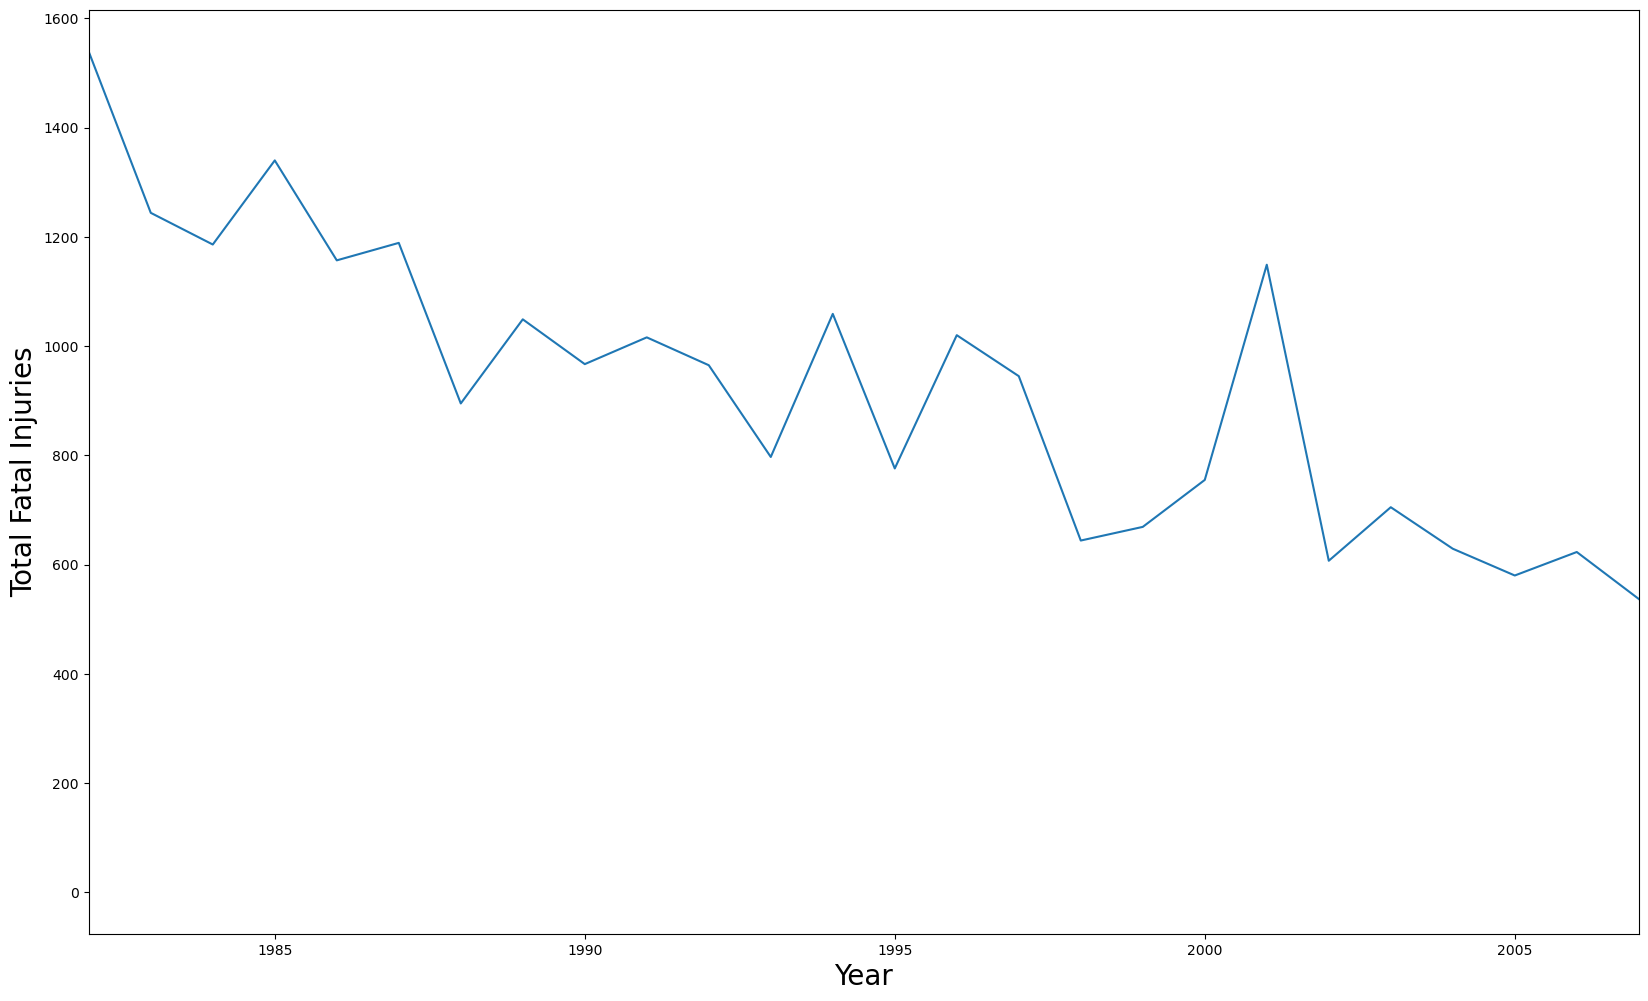

<AxesSubplot:xlabel='Weather.Condition', ylabel='Total.Fatal.Injuries'>

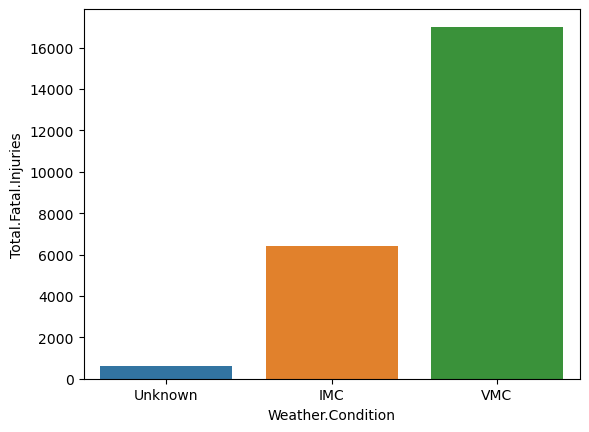

In [13]:
sns.barplot(data=df,x='Weather.Condition',y='Total.Fatal.Injuries',estimator=sum,ci=None)

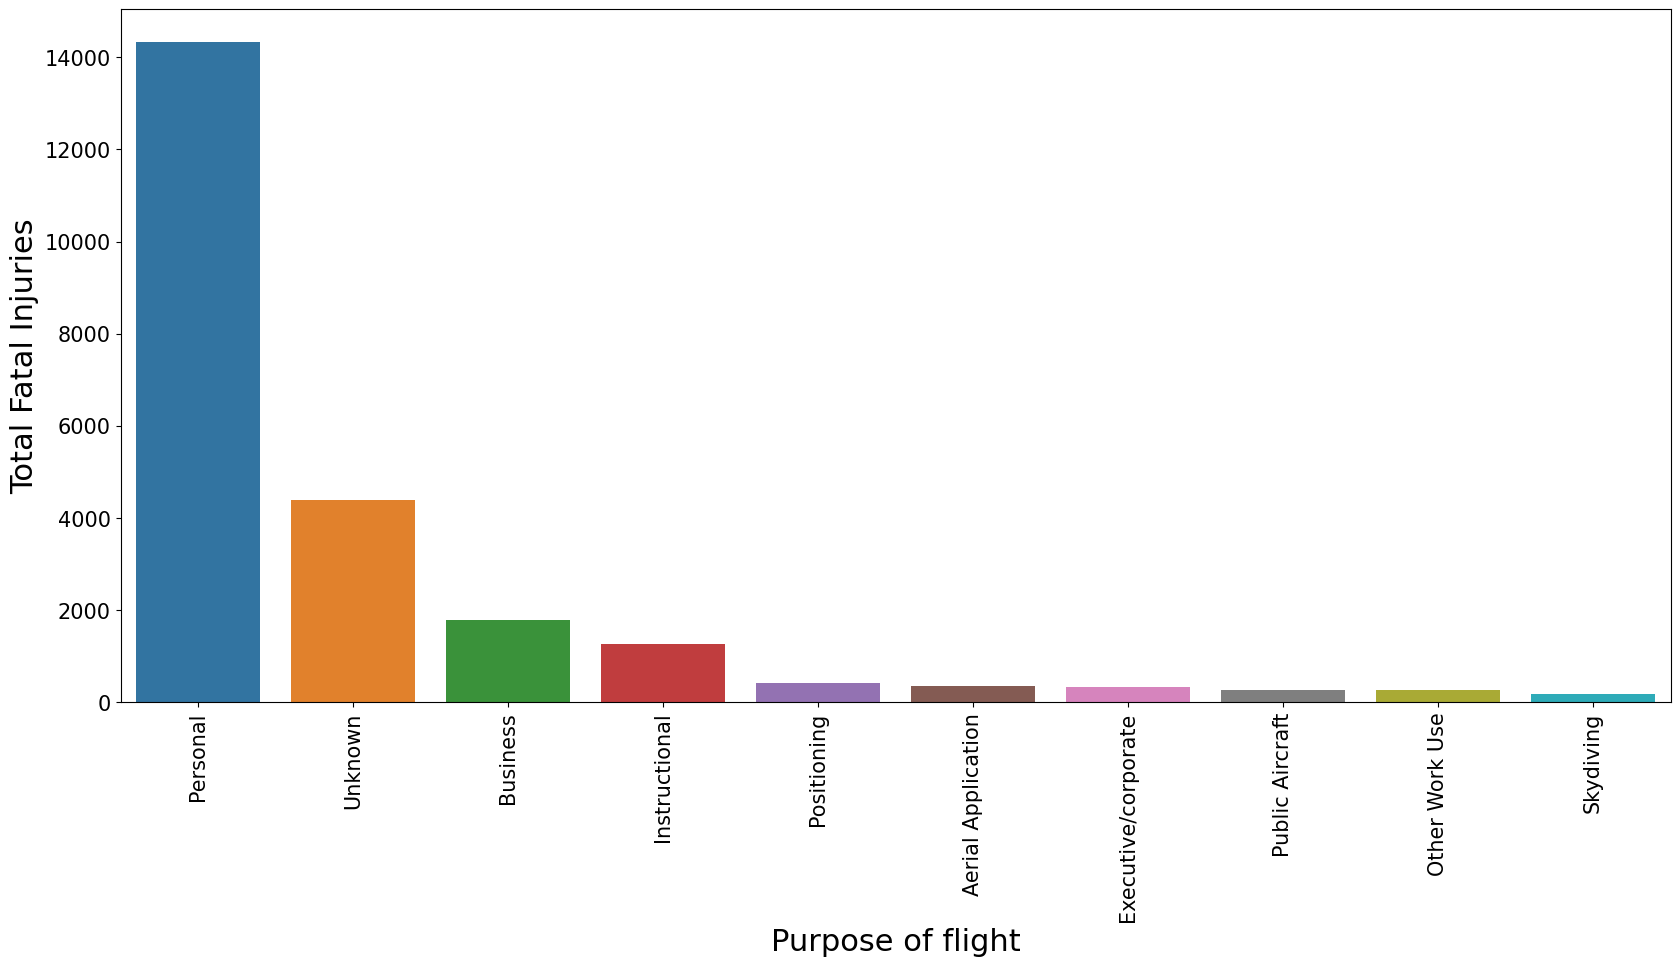

In [14]:
sorted_categories = df.groupby('Purpose.of.flight')['Total.Fatal.Injuries'].sum().sort_values(ascending=False).head(10).index

plt.figure(figsize=(20,9))
sns.barplot(data = df,x=df['Purpose.of.flight'],y=df['Total.Fatal.Injuries'],estimator=sum,ci=None,order=sorted_categories)
plt.xticks(rotation=90);
plt.ylabel("Total Fatal Injuries", size=22)
plt.xlabel("Purpose of flight", size=22)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

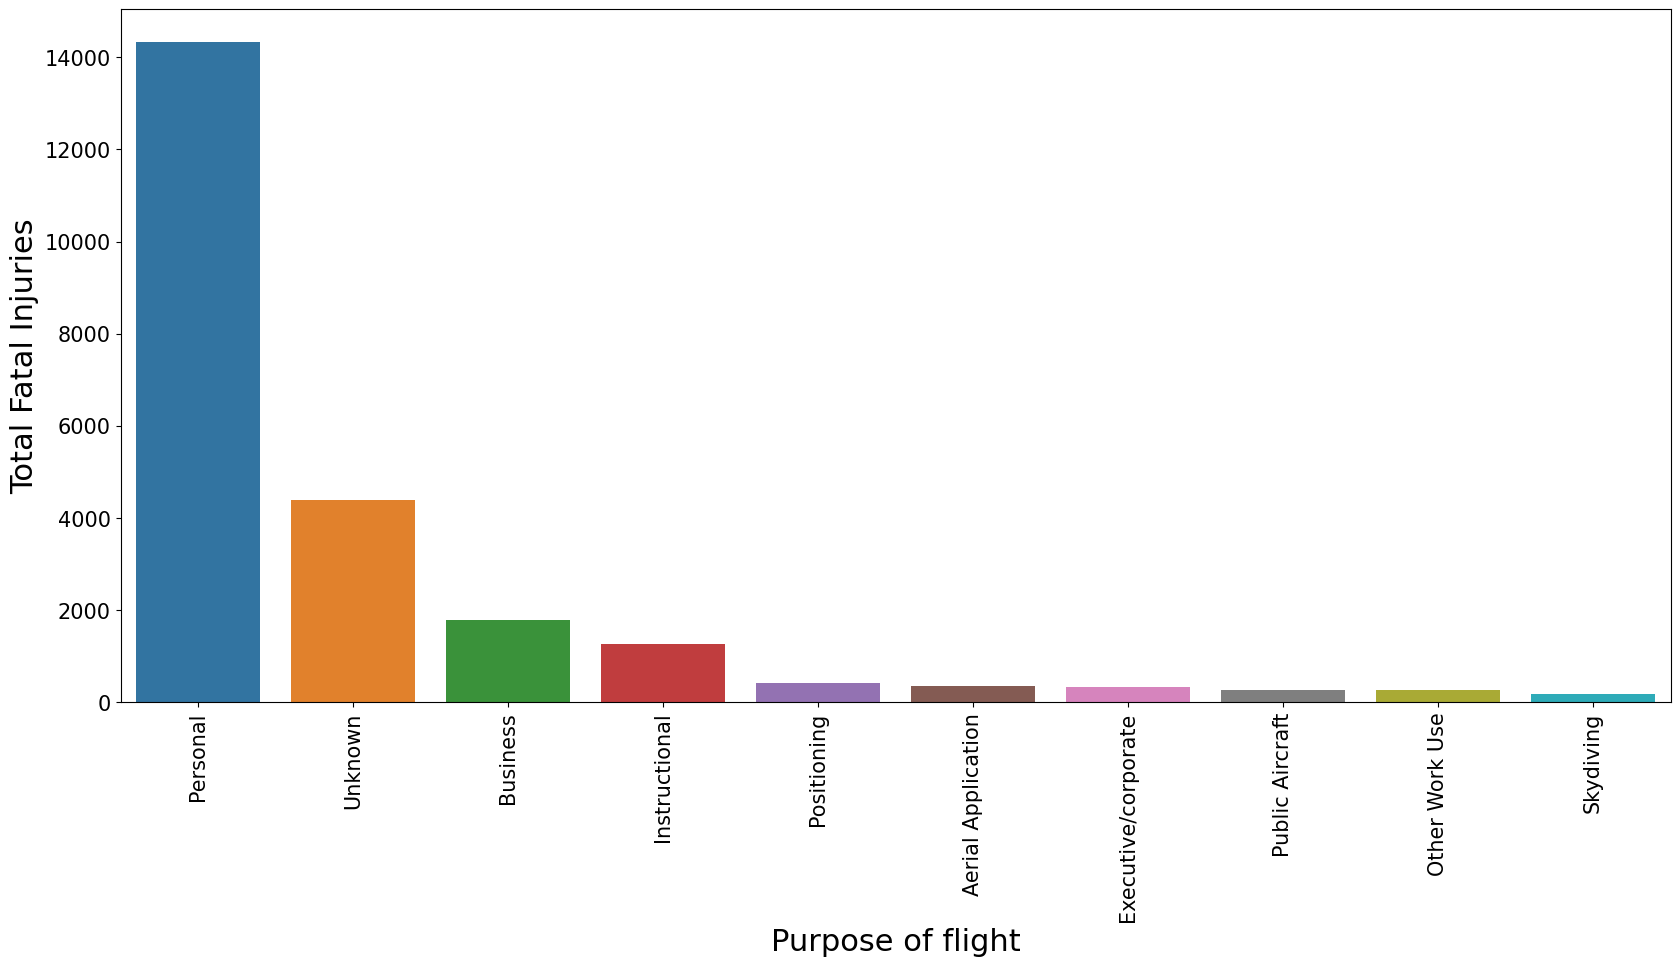

In [15]:
df.describe()

,Number.of.Engines,Total.Fatal.Injuries,Year
count,49498.000000,49498.000000,49498.000000
mean,1.134470,0.486040,1990.650693
std,0.410456,2.872832,6.206839
min,0.000000,0.000000,1948.000000
25%,1.000000,0.000000,1985.000000
50%,1.000000,0.000000,1990.000000
75%,1.000000,0.000000,1996.000000
max,4.000000,265.000000,2007.000000


In [16]:
df = df.reset_index()

In [17]:
df['Total.Fatal.Injuries_encoded'] = df['Total.Fatal.Injuries'].where(df['Total.Fatal.Injuries'] ==0, other=1)

In [18]:
df['Total.Fatal.Injuries_encoded'].value_counts()

0.0    38128
1.0    11370
Name: Total.Fatal.Injuries_encoded, dtype: int64

In [19]:
df_X = df[['Number.of.Engines', 'Engine.Type','Purpose.of.flight', 'Weather.Condition', 'Broad.phase.of.flight', 'Month']]

In [20]:
df_X['Number.of.Engines'] = df_X['Number.of.Engines'].astype(str)

C:\Users\sebas\AppData\Local\Temp\ipykernel_24612\2679873068.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_X['Number.of.Engines'] = df_X['Number.of.Engines'].astype(str)


In [21]:
df_X['Number.of.Engines']

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
49493    1.0
49494    1.0
49495    1.0
49496    1.0
49497    1.0
Name: Number.of.Engines, Length: 49498, dtype: object

In [22]:
lista_kolumn_X = list(df_X.columns)

for i in lista_kolumn_X:
    print(i, df_X[i].value_counts().count())

Number.of.Engines 5
Engine.Type 6
Purpose.of.flight 21
Weather.Condition 3
Broad.phase.of.flight 12
Month 12


In [23]:
df_X_get_dummies = pd.get_dummies(df_X)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df_X_get_dummies, df['Total.Fatal.Injuries_encoded'], test_size=0.3,random_state=123)

In [25]:
#RandomForestClassifier
'''
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve
rf_cls = RandomForestClassifier(max_depth=3)
rf_cls = rf_cls.fit(X_train, y_train)

pred_train = rf_cls.predict(X_train)
pred_test = rf_cls.predict(X_test)
print(classification_report(y_train,pred_train))
print(classification_report(y_test,pred_test))

pred_train_proba =  rf_cls.predict_proba(X_train)[:,1]
pred_test_proba = rf_cls.predict_proba(X_test)[:,1]
roc_auc_score(y_train,pred_train_proba)
roc_auc_score(y_test,pred_test_proba)

fpr_train, tpr_train, thresholds =roc_curve(y_train, pred_train_proba)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test,pred_test_proba)

plt.plot(fpr_train,tpr_train, color='r')
plt.plot(fpr_test,tpr_test, color='b')
plt.plot(np.arange(0,1,0.01),np.arange(0,1,0.01),'--')
plt.show()

print(f'Score train: {rf_cls.score(X_train,y_train)}')
print(f'Score train: {rf_cls.score(X_test,y_test)}')

rf_cls.feature_importances_
rf_cls.feature_names_in_

df_importance = pd.DataFrame(rf_cls.feature_importances_,rf_cls.feature_names_in_,columns=['importance']).sort_values(by='importance',ascending=False)
df_importance
'''

"\nfrom sklearn.metrics import classification_report\nfrom sklearn.metrics import roc_auc_score, roc_curve\nrf_cls = RandomForestClassifier(max_depth=3)\nrf_cls = rf_cls.fit(X_train, y_train)\n\npred_train = rf_cls.predict(X_train)\npred_test = rf_cls.predict(X_test)\nprint(classification_report(y_train,pred_train))\nprint(classification_report(y_test,pred_test))\n\npred_train_proba =  rf_cls.predict_proba(X_train)[:,1]\npred_test_proba = rf_cls.predict_proba(X_test)[:,1]\nroc_auc_score(y_train,pred_train_proba)\nroc_auc_score(y_test,pred_test_proba)\n\nfpr_train, tpr_train, thresholds =roc_curve(y_train, pred_train_proba)\nfpr_test, tpr_test, thresholds_test = roc_curve(y_test,pred_test_proba)\n\nplt.plot(fpr_train,tpr_train, color='r')\nplt.plot(fpr_test,tpr_test, color='b')\nplt.plot(np.arange(0,1,0.01),np.arange(0,1,0.01),'--')\nplt.show()\n\nprint(f'Score train: {rf_cls.score(X_train,y_train)}')\nprint(f'Score train: {rf_cls.score(X_test,y_test)}')\n\nrf_cls.feature_importances_\n

### XGB



#####  Best params

- booster: gbtree,
- learning_rate: 0.5,
- max_depth: 5,
- n_estimators: 74,
- num_boost_round: 100,
- custom_metric: balanced_accuracy,
- nfold: 5



In [26]:
df_X_get_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49498 entries, 0 to 49497
Data columns (total 59 columns):
 #   Column                                       Non-Null Count  Dtype
---  ------                                       --------------  -----
 0   Number.of.Engines_0.0                        49498 non-null  uint8
 1   Number.of.Engines_1.0                        49498 non-null  uint8
 2   Number.of.Engines_2.0                        49498 non-null  uint8
 3   Number.of.Engines_3.0                        49498 non-null  uint8
 4   Number.of.Engines_4.0                        49498 non-null  uint8
 5   Engine.Type_Reciprocating                    49498 non-null  uint8
 6   Engine.Type_Turbo Fan                        49498 non-null  uint8
 7   Engine.Type_Turbo Jet                        49498 non-null  uint8
 8   Engine.Type_Turbo Prop                       49498 non-null  uint8
 9   Engine.Type_Turbo Shaft                      49498 non-null  uint8
 10  Engine.Type_Unknown   

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df_X_get_dummies, df['Total.Fatal.Injuries_encoded'], test_size=0.3,random_state=123)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [28]:
params = { 
    "booster": "gbtree",
    "learning_rate": 0.5
}

In [29]:
def balanced_accuracy(preds, dtrain):
    labels = dtrain.get_label()
    preds_binary = (preds > 0.5).astype(int)
    return 'balanced_accuracy', balanced_accuracy_score(labels, preds_binary)

In [30]:
# for max_depth in [2,3,4,5,6,7,8,9]:
#     my_params = {"max_depth": max_depth}
#     my_params.update(params)
#     cv_results = xgb.cv(
#         dtrain=dtrain, 
#         params=my_params, 
#         nfold=5, 
#         num_boost_round=100, 
#         custom_metric=balanced_accuracy,
#         as_pandas=True)
#     best_rounds = cv_results['test-balanced_accuracy-mean'].idxmax()
#     score = cv_results['test-balanced_accuracy-mean'].max()
#     print("For max_depth {} the best result was {} after {} rounds".format(
#         max_depth, score, best_rounds
#     ))

In [31]:
my_params = {'max_depth':5,'n_estimators':74}
my_params.update(params)

In [32]:
best_model = xgb.XGBClassifier(**my_params)
best_model.fit(X_train,y_train)

preds = best_model.predict(X_test)
probas = best_model.predict_proba(X_test)[:, 1]

roc_auc_score(y_test, probas), f1_score(y_test, preds)

(0.8127382477876387, 0.5375)

In [33]:
best_model.score(X_test, y_test)

0.8206060606060606

In [34]:
y_pred = best_model.predict(X_test)

In [35]:
acc = accuracy_score(y_test,y_pred)
balanced_acc = balanced_accuracy_score(y_test,y_pred)

print(f'Accuracy score: {acc}')
print(f'Balanced accuracy score: {balanced_acc}')


Accuracy score: 0.8206060606060606
Balanced accuracy score: 0.6935377900207429


### Ocena i wyniki






|             |precision |recall |f1-score |support |
| ----------- |----------|-------|---------| -------|
|0.0          |0.86      |0.92   |0.89     |11499   |
|1.0          |0.64      |0.46   |0.54     |3351    |
|accuracy     |          |       |0.82     |14850   |
|macro avg    |0.75      |0.69   |0.71     |14850   |
|weighted avg |0.81      |0.82   |0.81     |14850   |

Balanced accuracy score: 0.6938114894269347


In [36]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.86      0.93      0.89     11499
         1.0       0.64      0.46      0.54      3351

    accuracy                           0.82     14850
   macro avg       0.75      0.69      0.71     14850
weighted avg       0.81      0.82      0.81     14850



In [37]:
cm = confusion_matrix(y_test,y_pred)

In [38]:
cm

array([[10638,   861],
       [ 1803,  1548]], dtype=int64)

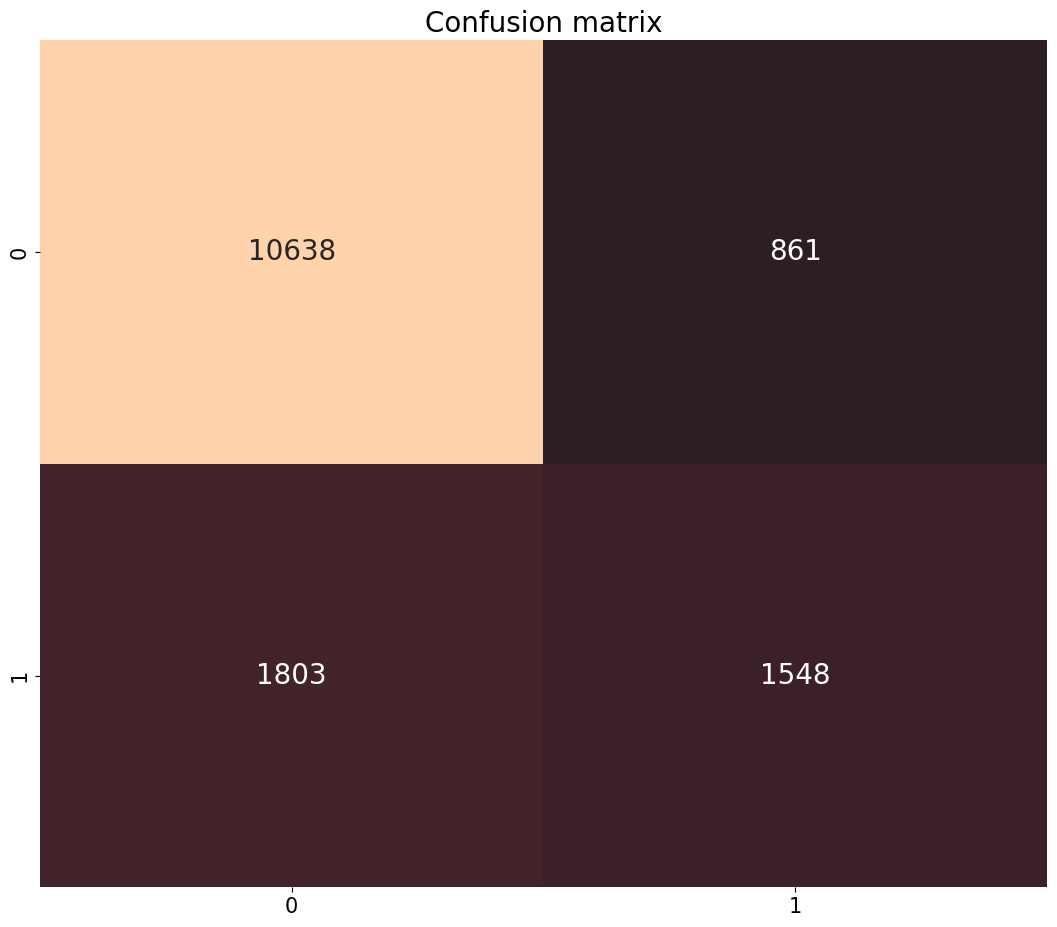

In [39]:
plt.figure(figsize=(13,11))
ax = sns.heatmap(cm,annot=True,fmt='g',center=True,cbar=False,annot_kws={"fontsize": 20})
plt.title('Confusion matrix',size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()
plt.show(ax)

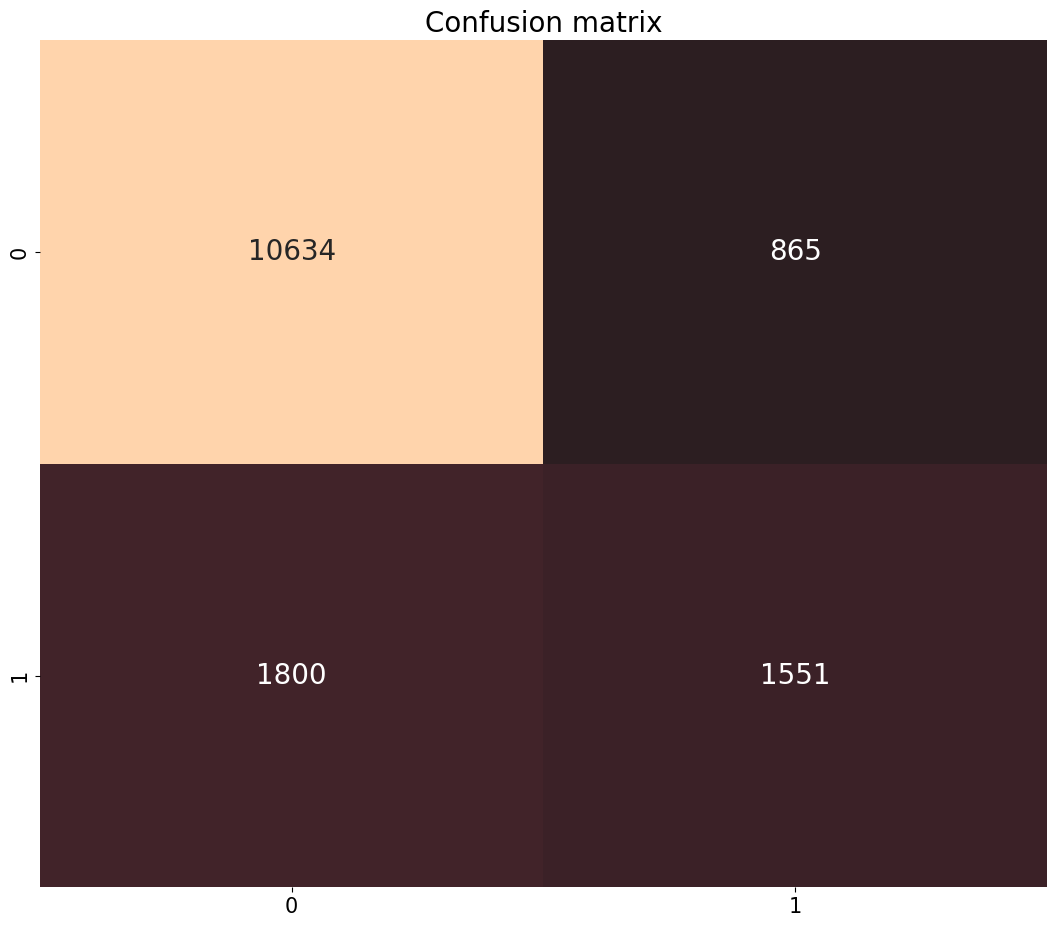

In [40]:
probas = best_model.predict_proba(X_test)

In [41]:
positive_proba = probas[:, 1]

Text(0, 0.5, 'True positive rate')

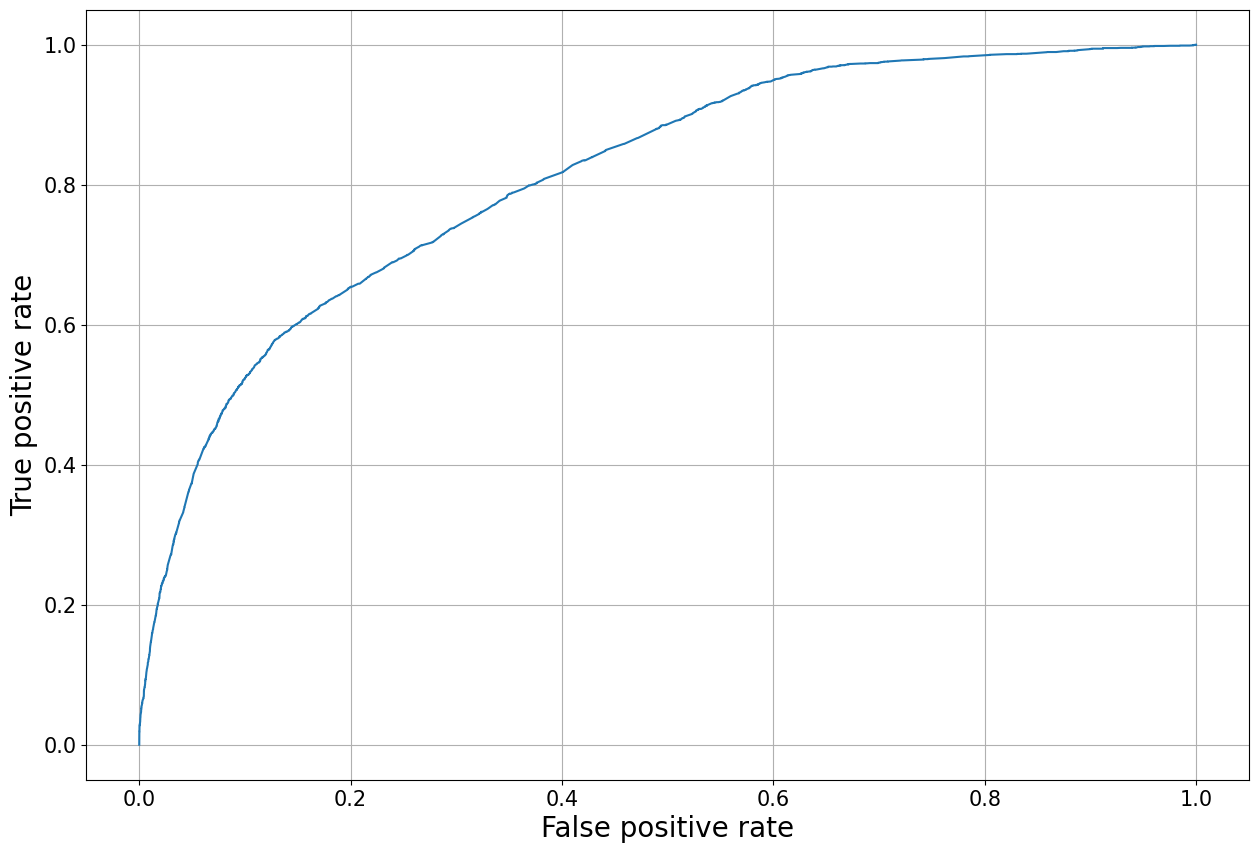

In [42]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, positive_proba)

plt.figure(figsize=(15, 10))
plt.plot(false_positive_rate, true_positive_rate)
plt.grid()
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel("False positive rate",size=20)
plt.ylabel("True positive rate",size=20)

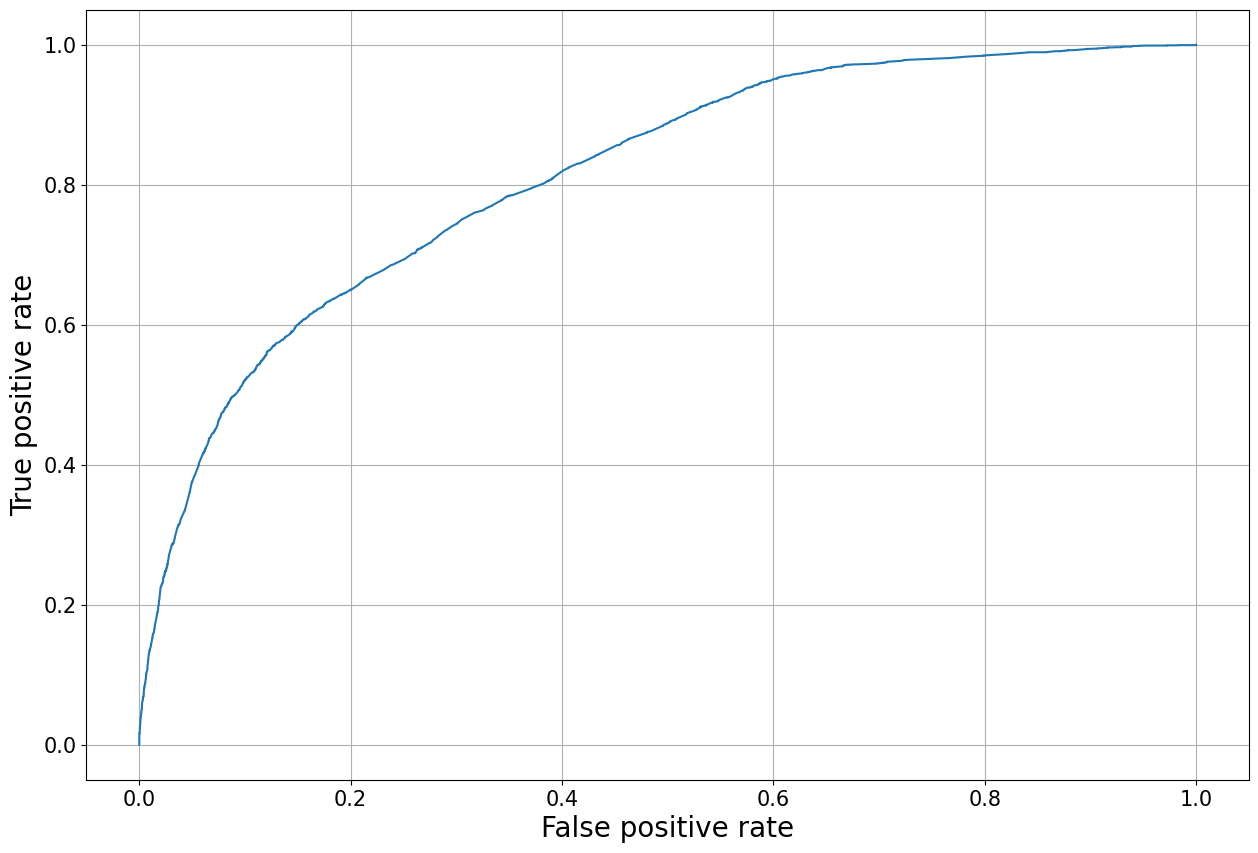

Text(0, 0.5, 'Features')

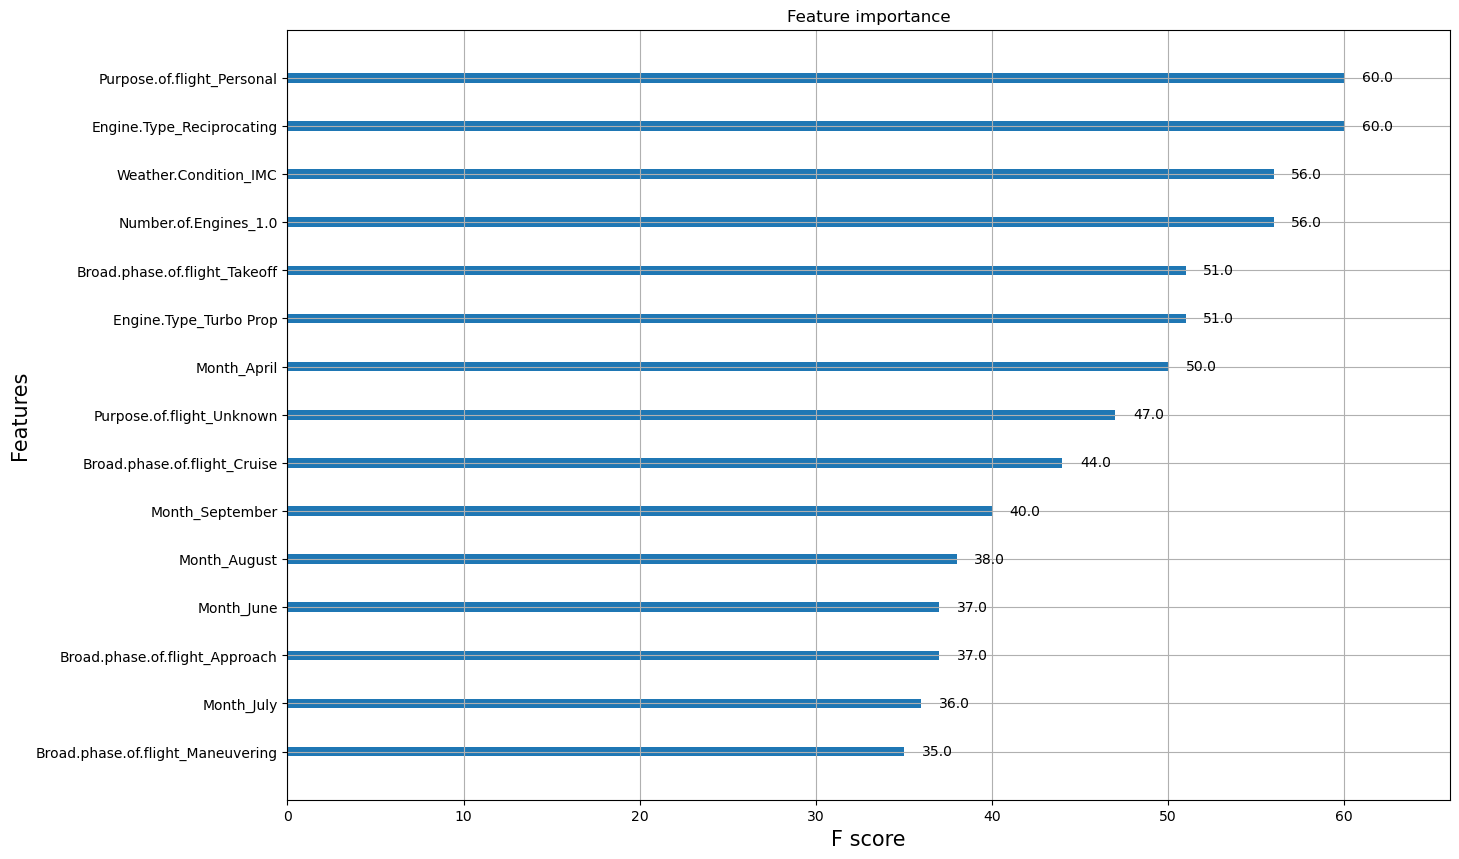

In [55]:
ax = xgb.plot_importance(best_model,max_num_features=15)
fig = ax.figure
fig.set_size_inches(15, 10)
plt.xticks(size=10)
plt.yticks(size=10)
plt.xlabel("F score",size=15)
plt.ylabel("Features",size=15)

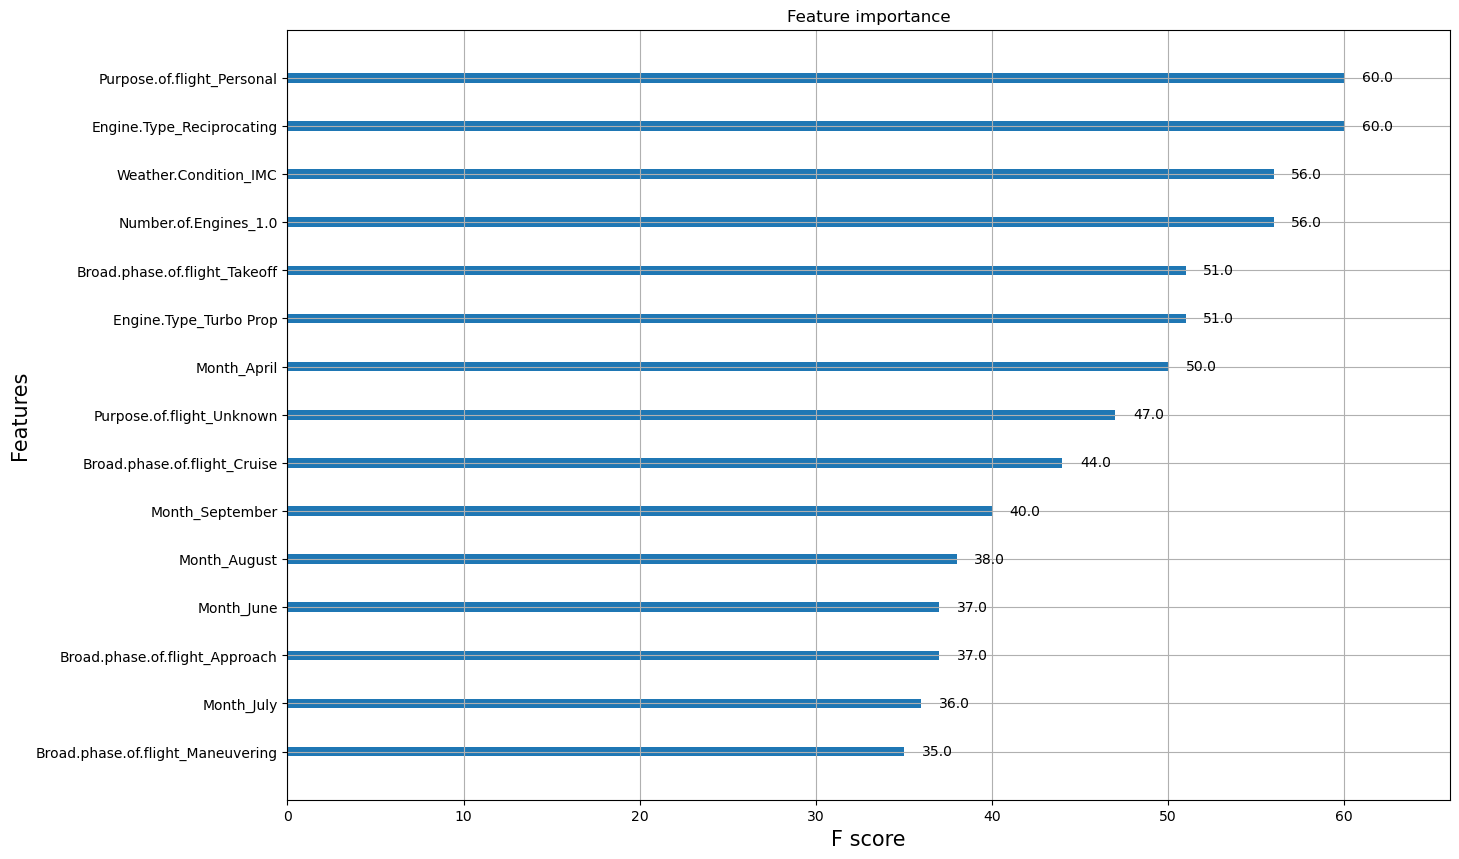